In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"

plt.rcParams.update({'font.size': 14})
%config InlineBackend.figure_format = 'retina'

import os
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
os.chdir(parent_dir)

from src.skycycles.model import CyclesGraph

%load_ext autoreload
%autoreload 2

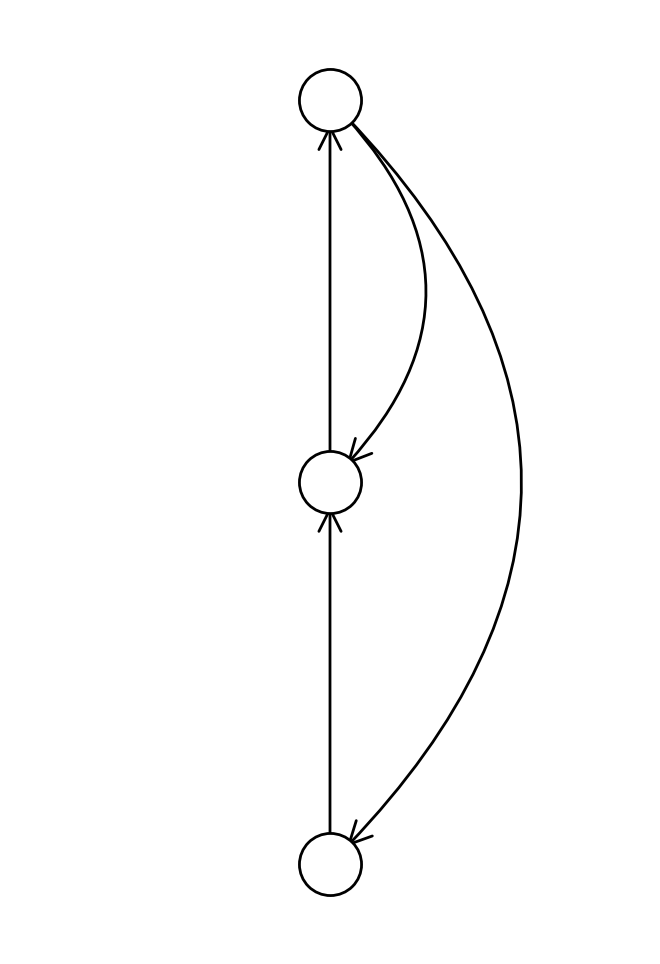

In [2]:
Theta = np.array([[1, 1], [0, 1]])
T = np.array([6, 3])

import networkx as nx

G = nx.DiGraph()
G.add_nodes_from(['A', 'B', 'C'])
edges = [('B', 'A'), ('A', 'B'), ('B', 'C'), ('C', 'B')]
G.add_edges_from(edges)
pos = {'A': (0, 2), 'B': (0, 1), 'C': (0, 0)}
plt.figure(figsize=(4, 6))
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='white', edgecolors='black')
nx.draw_networkx_edges(
    G, pos,
    edgelist=[('B', 'A'), ('C', 'B')],
    edge_color='black',
    arrowsize=20,
    arrowstyle='->',
    connectionstyle='arc3,rad=0'  # Straight line
)
nx.draw_networkx_edges(
    G, pos,
    edgelist=[('A', 'B'), ('A', 'C')],
    edge_color='black',
    arrowsize=20,
    arrowstyle='->',
    connectionstyle='arc3,rad=-0.5'  # Curved line
)
plt.show()


In [3]:
def check(Theta, T, b, n, t_sol, f_sol):
    assert np.allclose(np.minimum(np.array(t_sol), 0), 0), f"{t_sol=}"
    assert np.allclose(n / f_sol - T, Theta @ t_sol), f"{n / f_sol - T=}, {Theta @ t_sol=}"
    assert np.allclose(np.maximum(Theta.T @ f_sol - b, 0), 0), f"{Theta.T @ f_sol=}, {b=}" 
    assert np.allclose(np.maximum(0, b - Theta.T @ f_sol) * t_sol, 0), f"{np.maximum(0, b - Theta.T @ f_sol) * t_sol=}"
    
def compare(b, n, t_sol, f_sol, t, f, rtol=3e-1, atol=1e-5):  # huge allowed error: 30%
    assert np.allclose(t, t_sol, rtol=rtol, atol=atol) and np.allclose(f, f_sol, rtol=rtol, atol=atol), (f"{b=} " + f"{n=} " + f"{t=} " + f"{t_sol=} " + f"{f=} " + f"{f_sol=}")

In [4]:
def solve_t2_case4(T, b, n):
    b1, b2 = b
    T1, T2 = T
    n1, n2 = n
    
    b = b2 * (T1 + T2) - n1 - n2
    a = b2
    c = b2 * T1 * T2 - n1 * T2 - n2 * T1
    
    Droot = (b ** 2 - 4 * a * c) ** 0.5
    
    return (-b + Droot) / (2 * a)  # second root (-b - Droot) / (2 * a) is negative

In [5]:
def check_no_ass(Theta, T, b, n, t_sol, f_sol, log=False, case=None):
    t_noneq = np.allclose(np.minimum(np.array(t_sol), 0), 0), f"{t_sol=}"
    queue_time = np.allclose(n / f_sol - T, Theta @ t_sol), f"{n / f_sol - T=}, {Theta @ t_sol=}"
    cap = np.allclose(np.maximum(Theta.T @ f_sol - b, 0), 0), f"{Theta.T @ f_sol=}, {b=}" 
    compl_slack = np.allclose(np.maximum(0, b - Theta.T @ f_sol) * t_sol, 0), f"{np.maximum(0, b - Theta.T @ f_sol) * t_sol=}"
    
    conds = [t_noneq, queue_time, cap, compl_slack]
    
    if log:
        for cond in conds:
            if not cond[0]:
                print(f"(case search) Case {case} inconsistent:", cond[1])
    
    ok = np.all([cond[0] for cond in conds])
    if log and ok:
        print(f"(case search) Case {case} ok")
        
    return ok  

def solve(T, b, n, log=False):
    # case 1: no queues (t = 0)
    t_sol = [0, 0]
    f_sol = n / T
    if check_no_ass(Theta, T, b, n, t_sol, f_sol, log, 1):
        return t_sol, f_sol, 1
    
    # case 2:  t1 > 0, t2 = 0
    t_sol = [n[0] / b[0] - T[0], 0]
    f_sol = [b[0], n[1] / T[1]]
    if check_no_ass(Theta, T, b, n, t_sol, f_sol, log, 2):
        return t_sol, f_sol, 2
        
    # case 3: t1 > 0, t2 > 0
    if b[1] > b[0]:
        t2 = n[1] / (b[1] - b[0]) - T[1]
        t1 = n[0] / b[0] - t2 - T[0]
        t_sol = np.array([t1, t2])
        f_sol = np.array([b[0], b[1] - b[0]])
        if check_no_ass(Theta, T, b, n, t_sol, f_sol, log, 3):
            return t_sol, f_sol, 3
    
    # case 4: t1 = 0, t2 > 0
    t2 = solve_t2_case4(T, b, n)
    t_sol = [0, t2]
    f_sol = [n[0] / (t2 + T[0]), n[1] / (t2 + T[1])]
    if check_no_ass(Theta, T, b, n, t_sol, f_sol, log, 4):
        assert np.isclose(f_sol[1], b[1] - f_sol[0]), f"{f_sol[1] =}, {b[1] - f_sol[0]=}" 
        return t_sol, f_sol, 4
     
    return [None, None], [None, None], None

# b = [1, 1]
# n = np.array([7, 1])
# solve(T, b, n, log=True)

In [6]:
# Plot analytic solution while changing n[0]

b = [1, 1.3]
n = np.array([7.0, 1])

t1s = []
t2s = []
# b1s = np.linspace(1, 1.4, 100)
n1s = np.linspace(5, 7, 100)
cases = []
for n1 in n1s:
    n[0] = n1
    t_sol, f_sol, case = solve(T, b, n)
    t1s.append(t_sol[0])
    t2s.append(t_sol[1])
    cases.append(case)
    
# Create a figure and axis
plt.figure(figsize=(10, 6))
# Plot each case with a different color
for case_num in np.arange(1, 5):
    # Create mask for this case
    mask = np.array(cases) == case_num
    plt.plot(np.array(n1s)[mask], np.array(t1s)[mask], label=f'Case {case_num}')
    
plt.plot(n1s, t2s, color="grey", label="t2")

# Add legend and labels
plt.legend()
plt.xlabel('n1 values')
plt.ylabel('t1 values')
plt.title('t1 values for different cases')

Text(0.5, 1.0, 't1 values for different cases')

Error in callback <function _draw_all_if_interactive at 0x1071265f0> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1000x600 with 1 Axes>

In [7]:
# TODO: run via pytest

graph = CyclesGraph()

methods = ["cvxpy", "scipy", "gradient"]
def test(T, b, n):
    t, f = graph.solve_lift_system(Theta, T, b, n, method=methods[0])
    t_sol, f_sol, _ = solve(T, b, n, log=True)
    check(Theta, T, b, n, t_sol, f_sol)
    compare(b, n, t_sol, f_sol, t, f, rtol=1e-2)
    print("Test ok! \n")
    

# case 1: no queues (t = 0)
b = [1, 1]
n = np.array([1, 1])
test(T, b, n)

# case 2: t1 > 0, t2 = 0
b = [1, 2]
n = np.array([7, 1])
test(T, b, n)

# case 3: t1 > 0, t2 > 0
b = [1, 1.3]
n = np.array([7, 1])
test(T, b, n)

# case 4: t1 = 0, t2 > 0
b = [1, 1.3]
n = np.array([6, 1])
test(T, b, n)


(case search) Case 1 ok
Test ok! 

(case search) Case 1 inconsistent: Theta.T @ f_sol=array([1.16666667, 1.5       ]), b=[1, 2]
(case search) Case 2 ok
Test ok! 

(case search) Case 1 inconsistent: Theta.T @ f_sol=array([1.16666667, 1.5       ]), b=[1, 1.3]
(case search) Case 2 inconsistent: Theta.T @ f_sol=array([1.        , 1.33333333]), b=[1, 1.3]
(case search) Case 3 ok
Test ok! 

(case search) Case 1 inconsistent: Theta.T @ f_sol=array([1.        , 1.33333333]), b=[1, 1.3]
(case search) Case 2 inconsistent: Theta.T @ f_sol=array([1.        , 1.33333333]), b=[1, 1.3]
(case search) Case 3 inconsistent: t_sol=array([-0.33333333,  0.33333333])
(case search) Case 4 ok
Test ok! 



In [8]:
# Random tests for a simpler graph: two independent cycles

graph = CyclesGraph()
Theta_ = np.identity(2)
T_ = np.array([1, 1])

b = [1, 2]
n = [0.5, 0.5]
t, f = graph.solve_lift_system(Theta_, T_, b, n)
assert np.allclose(t, [0, 0]) and np.allclose(f, 0.5)

b = [1, 2]
n = [1, 1]
t, f = graph.solve_lift_system(Theta_, T_, b, n)
assert np.allclose(t, [0, 0]) and np.allclose(f, 1)

for _ in range(100):
    b = np.array([1, 2])
    n = np.random.random(size=2) * 3
    t_sol = np.maximum(0, n / b - T_)
    f_sol = np.minimum(n / T_, b)
    t, f = graph.solve_lift_system(Theta_, T_, b, n)
    compare(b, n, t_sol, f_sol, t, f)
    
    